# Classification Level 2 

## data loading

In [16]:
import joblib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

processed_path = "../data/processed/"
# Load UN-scaled data
X_full_raw = joblib.load(os.path.join(processed_path, "X_unscaled.joblib"))
y_bin = joblib.load(os.path.join(processed_path, "y_lvl1.joblib"))
y_multi = joblib.load(os.path.join(processed_path, "y_lvl2_encoded.joblib"))

# --- Level 2 Filtering: Attacks Only ---
X_attack_raw = X_full_raw[y_bin == 1]
y_attack_raw = y_multi[y_bin == 1]

# Re-encode for XGBoost (0 to N-1)
le = LabelEncoder()
y_attack = le.fit_transform(y_attack_raw)
mapping = dict(zip(range(len(le.classes_)), le.classes_))
print(f"Attack data loaded (unscaled): {X_attack_raw.shape}")
print(f"Mapping: {mapping}")


Attack data loaded (unscaled): (556556, 62)
Mapping: {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7}


## Data Split And scaler


In [17]:
# 1. Split FIRST
X_train_raw, X_temp_raw, y_train, y_temp = train_test_split(
    X_attack_raw, y_attack, test_size=0.3, random_state=42, stratify=y_attack
)
X_val_raw, X_test_raw, y_val, y_test = train_test_split(
    X_temp_raw, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# 2. Fit scaler ONLY on malicious train set
scaler_l2 = StandardScaler()
X_train = scaler_l2.fit_transform(X_train_raw)
X_val = scaler_l2.transform(X_val_raw)
X_test = scaler_l2.transform(X_test_raw)

# Save scaler
os.makedirs("../data/trained_models/", exist_ok=True)
joblib.dump(scaler_l2, "../data/trained_models/scaler_lvl2.joblib")


['../data/trained_models/scaler_lvl2.joblib']

## Training : Model Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
print("Training Random Forest...")
rf_multi = RandomForestClassifier(
    n_estimators=50, 
    max_depth=15, 
    class_weight='balanced', 
    n_jobs=-1, 
    random_state=42
)
rf_multi.fit(X_train, y_train)
# Validation check
y_val_pred = rf_multi.predict(X_val)
print("\n--- Validation Report (RF) ---")
print(classification_report(y_val, y_val_pred))
print(f"Macro F1 (Validation): {f1_score(y_val, y_val_pred, average='macro'):.4f}")

Training Random Forest...

--- Validation Report (RF) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       294
           1       1.00      0.93      0.96      2301
           2       1.00      1.00      1.00     19203
           3       1.00      1.00      1.00     37757
           4       1.00      1.00      1.00     23820
           5       1.00      0.71      0.83         7
           6       0.36      0.86      0.51       101

    accuracy                           1.00     83483
   macro avg       0.91      0.93      0.90     83483
weighted avg       1.00      1.00      1.00     83483

Macro F1 (Validation): 0.9012


## Training  Model : XGBoost

In [19]:
from xgboost import XGBClassifier
print("Training XGBoost with Early Stopping...")
xgb_multi = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    objective='multi:softprob',
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=10
)
# Fit using validation set
xgb_multi.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)
# Validation check
y_val_pred_xgb = xgb_multi.predict(X_val)
print("\n--- Validation Report (XGBoost) ---")
print(classification_report(y_val, y_val_pred_xgb))
print(f"Macro F1 (Validation): {f1_score(y_val, y_val_pred, average='macro'):.4f}")

Training XGBoost with Early Stopping...

--- Validation Report (XGBoost) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       294
           1       0.97      0.99      0.98      2301
           2       1.00      1.00      1.00     19203
           3       1.00      1.00      1.00     37757
           4       1.00      1.00      1.00     23820
           5       1.00      0.71      0.83         7
           6       0.50      0.20      0.28       101

    accuracy                           1.00     83483
   macro avg       0.92      0.84      0.87     83483
weighted avg       1.00      1.00      1.00     83483

Macro F1 (Validation): 0.9012


# Test Final et sauvegarde du meilleur model


--- FINAL TEST REPORT (Level 2) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       293
           1       1.00      0.94      0.97      2301
           2       1.00      1.00      1.00     19204
           3       1.00      1.00      1.00     37757
           4       1.00      1.00      1.00     23821
           5       1.00      0.86      0.92         7
           6       0.38      0.90      0.53       101

    accuracy                           1.00     83484
   macro avg       0.91      0.96      0.92     83484
weighted avg       1.00      1.00      1.00     83484

FINAL Macro F1 (Test): 0.9171


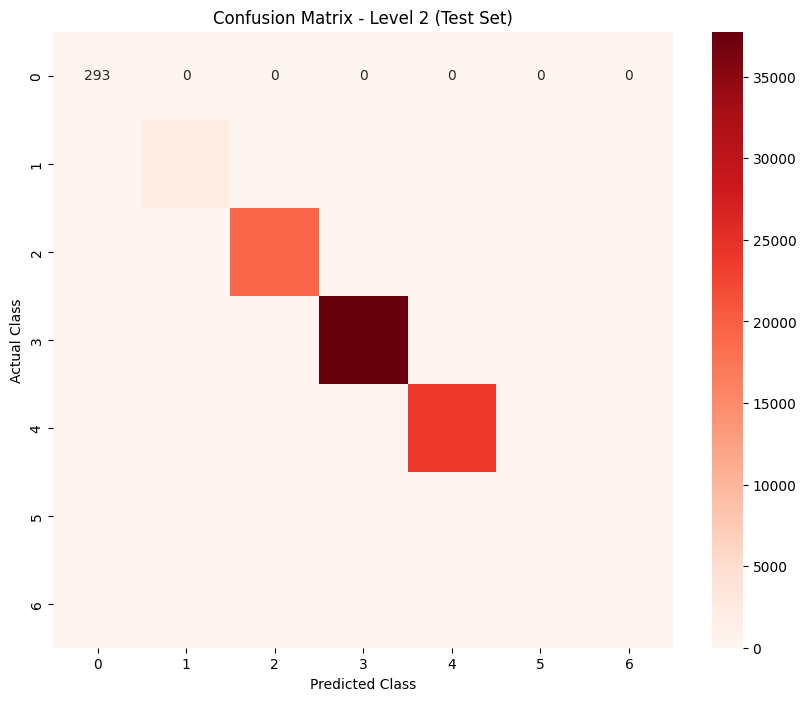

Model and LabelEncoder saved successfully.


In [20]:
# Final predictions on Test set
y_test_pred = rf_multi.predict(X_test)
print("\n--- FINAL TEST REPORT (Level 2) ---")
# This report shows accuracy, precision, recall, and F1 per attack family
print(classification_report(y_test, y_test_pred))
print(f"FINAL Macro F1 (Test): {f1_score(y_test, y_test_pred, average='macro'):.4f}")
# Confusion Matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix - Level 2 (Test Set)")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()
# Save the multi-class model AND the encoder
model_path = "../data/trained_models/"
joblib.dump(rf_multi, os.path.join(model_path, "model_lvl2_multiclass.joblib"))
joblib.dump(le, os.path.join(model_path, "label_encoder_lvl2_final.joblib"))
print("Model and LabelEncoder saved successfully.")